In [1]:
colab = False
if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  colab = True
else:
  print('Not running on CoLab')

Running on CoLab


In [2]:
if colab:
    ! pip install --upgrade --force-reinstall --no-deps kaggle
    ! mkdir /root/.kaggle
    ! cp kaggle.json /root/.kaggle/
    ! chmod 600 /root/.kaggle/kaggle.json
    ! kaggle competitions download -c ranzcr-clip-catheter-line-classification -p ./data/
    ! unzip ./data/'*.zip' -d ./data

Streaming output truncated to the last 5000 lines.
  inflating: ./data/train/1.2.826.0.1.3680043.8.498.80037468194220420320170944397575295227.jpg  
  inflating: ./data/train/1.2.826.0.1.3680043.8.498.80048407175337306557451404132392019931.jpg  
  inflating: ./data/train/1.2.826.0.1.3680043.8.498.80058141917130703975834534533058558900.jpg  
  inflating: ./data/train/1.2.826.0.1.3680043.8.498.80062845141741671052045396402379570613.jpg  
  inflating: ./data/train/1.2.826.0.1.3680043.8.498.80065354188180228774750311922384866730.jpg  
  inflating: ./data/train/1.2.826.0.1.3680043.8.498.80065596468977553272320950387981297089.jpg  
  inflating: ./data/train/1.2.826.0.1.3680043.8.498.80068774453246950728257986408626689267.jpg  
  inflating: ./data/train/1.2.826.0.1.3680043.8.498.80068841941683185471103184447222880939.jpg  
  inflating: ./data/train/1.2.826.0.1.3680043.8.498.80075763966903465802988353073871382997.jpg  
  inflating: ./data/train/1.2.826.0.1.3680043.8.498.800761326103369192416724

In [5]:
if colab:
    ! pip3 install pandas_profiling --upgrade

     |████████████████████████████████| 245kB 5.6MB/s 
     |████████████████████████████████| 604kB 7.5MB/s 
     |████████████████████████████████| 81kB 6.3MB/s 
     |████████████████████████████████| 3.1MB 11.1MB/s 
     |████████████████████████████████| 61kB 6.0MB/s 
     |████████████████████████████████| 81kB 7.7MB/s 
     |████████████████████████████████| 296kB 38.2MB/s 
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp36-none-any.whl size=27085 sha256=91466c7573d83a5c9caf714a8631e7fcaf7c7bb05b24fce757bc3577ec123a0c
  Stored in directory: /root/.cache/pip/wheels/43/07/ac/7c5a9d708d65247ac1f94066cf1db075540b85716c30255459
  Created wheel for phik: filename=phik-0.11.0-cp36-none-any.whl size=599738 sha256=d2cf5946b65eb0a17e23e887016a9e2671021b80f8458aece3d992ff61993e6d
  Stored in directory: /root/.cache/pip/wheels/af/54/11/aba77f21075918de02f7964eabfe8c10d5542df9e6ad10b225
Successfully built htmlmin phik
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import permutations
from pandas_profiling import ProfileReport
from matplotlib_venn import venn3
import warnings
from pathlib import Path
import cv2
import json
from collections import Counter
import pickle
warnings.filterwarnings("ignore")
%matplotlib inline

In [7]:
data_folder = 'data'
data_file = 'ranzcr-clip-catheter-line-classification.zip'
file = Path('.') / data_folder / data_file

train_file = Path('.') / data_folder / 'train.csv'
train_annotations_file = Path('.') / data_folder / 'train_annotations.csv'
#train_img_folder = Path('.') / data_file / 'train'
train_img_folder = Path('.') / data_folder/ 'train'


train_df = pd.read_csv(train_file)
path_df = pd.read_csv(train_annotations_file)

def series_counts(series: pd.Series, dropna: bool = False, sort_index=False) -> pd.DataFrame:
    """

    :param series:
    :param dropna:
    :param sort_index:
    :return:
    """
    if sort_index:
        df = pd.concat(
            [series.value_counts(dropna=dropna).sort_index().rename('count'),
             series.value_counts(dropna=dropna, normalize=True).sort_index().rename('% of total'),
             series.value_counts(dropna=dropna, normalize=True).sort_index().cumsum().rename('cumulative %')],
            axis=1)

    else:
        df = pd.concat(
            [series.value_counts(dropna=dropna).rename('count'),
             series.value_counts(dropna=dropna, normalize=True).rename('% of total'),
             series.value_counts(dropna=dropna, normalize=True).cumsum().rename('cumulative %')],
            axis=1)
    df.index.rename(series.name, inplace=True)
    return df


def get_annotations(img_id: str, file_path: Path = train_annotations_file) -> list:
    """Given an image id, returns a list of numpy arrays of the tube placement.

    :param img_id: A string of the image id.
    :param file_path: A Path of the train annotations file.
    :return: A list of numpy arrays of the tube placement.
    """
    df = pd.read_csv(file_path)
    data = df.loc[df.StudyInstanceUID == img_id, 'data']
    if data.empty:
        return []
    return [np.array(json.loads(row)) for row in data]


def plot_annotations(ax, annotations: list) -> None:
    """Given a matplotlib plot Axes and a list of numpy arrays of tube placements,
    Plots the tube placements on the axis.

    :param ax: matplotlib plot Axes
    :param annotations: A list of numpy arrays of the tube placement.
    """
    for annotation in annotations:
        ax.scatter(annotation[:, 0], annotation[:, 1])


def show_image(ax, image_id, folder=train_img_folder, data=train_df) -> None:
    """
    
    :param ax:
    :param image_id:
    :param folder:
    :param data:
    """
    image_file = folder / Path(f'{image_id}.jpg')
    img = cv2.imread(str(image_file))
    data_row = data.loc[data.StudyInstanceUID == image_id]
    ax.imshow(img)
    ax.set_title(get_record_info(data_row.iloc[0]))


def get_record_info(train_row) -> str:
    """

    :param train_row:
    :return:
    """
    patient_id = train_row.PatientID
    ett_fields = ['ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal']
    ngt_fields = ['NGT - Abnormal', 'NGT - Borderline', 'NGT - Incompletely Imaged', 'NGT - Normal']
    cvc_fields = ['CVC - Abnormal', 'CVC - Borderline', 'CVC - Normal']
    ett0, ett1, ett2 = [train_row[ett] for ett in ett_fields]
    ngt0, ngt1, ngt2, ngt3 = [train_row[ngt] for ngt in ngt_fields]
    cvc0, cvc1, cvc2 = [train_row[cvc] for cvc in cvc_fields]
    if not (ett0, ett1, ett2):
        ett = ''
    else:
        ett = f'Endotracheal tube: Abnormal - {ett0:,}; Borderline - {ett1:,}; Normal - {ett2:,}'

    if not (ngt0, ngt1, ngt2, ngt3):
        ngt = ''
    else:
        ngt = f'Nasogastric tube: Abnormal - {ngt0:,}; Borderline - {ngt1:,}; Incompletely Imaged {ngt2:,} Normal - {ngt3:,}'

    if not (cvc0, cvc1, cvc2):
        cvc = ''
    else:
        cvc = f'Central venous catheter tube: Abnormal - {cvc0:,}; Borderline - {cvc1:,}; Normal - {cvc2:,}'

    sgcp = train_row['Swan Ganz Catheter Present']
    if sgcp:
        sgcp_msg = f'\nSwan Ganz Catheter Present - {sgcp}'
    else:
        sgcp_msg = ''

    msg = [f'Patient id: {patient_id}', ett, ngt, cvc]
    return '\n'.join([m for m in msg if m]) + sgcp_msg


def plot_img(image_id: str,
             train_file: pd.DataFrame = train_df,
             annotations_path: Path = train_annotations_file,
             folder=train_img_folder,
             show_annotations=True,
             figsize=None,
             ax=None):
    figsize = (8, 8) if figsize is None else figsize
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    show_image(ax, image_id, folder=folder, data=train_file)

    if show_annotations:
        annotations = get_annotations(image_id, file_path=annotations_path)
        plot_annotations(ax, annotations)

    return ax

In [8]:
df = train_df

In [9]:
profile = ProfileReport(df)
profile

Summarize dataset:   0%|          | 0/26 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Patients data

## Scans per patient

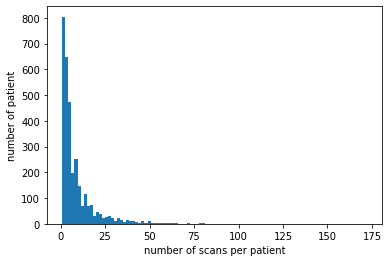

In [10]:
plt.hist(df['PatientID'].value_counts(), bins=100)
plt.xlabel('number of scans per patient')
plt.ylabel('number of patient')
plt.show()

## Multiplay catheters of the same type

In [11]:
print('Patients with more then one EET')
print(df[((df.iloc[:,1:4]==1).sum(axis=1) > 1)].shape[0])

Patients with more then one EET
0


In [12]:
print('Patients with more then one NGT')
print(df[((df.iloc[:,4:8]==1).sum(axis=1) > 1)].shape[0])

Patients with more then one NGT
45


In [13]:
print('Patients with more then one CVC')
print(df[((df.iloc[:,8:11]==1).sum(axis=1) > 1)].shape[0])

Patients with more then one CVC
3575


# Picture examples

## only one type images

ETT - Normal

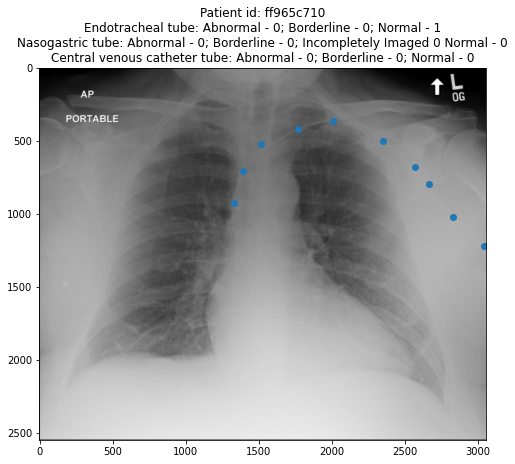

In [14]:
img_ids = df[(df.iloc[:,1:12].sum(axis=1) == 1) & df['ETT - Normal'] == 1]['StudyInstanceUID']
img_id = path_df[path_df['StudyInstanceUID'].apply(lambda id: id in img_ids.to_list())]['StudyInstanceUID'].iloc[3]
plot_img(img_id)
plt.show()

ETT - Borderline

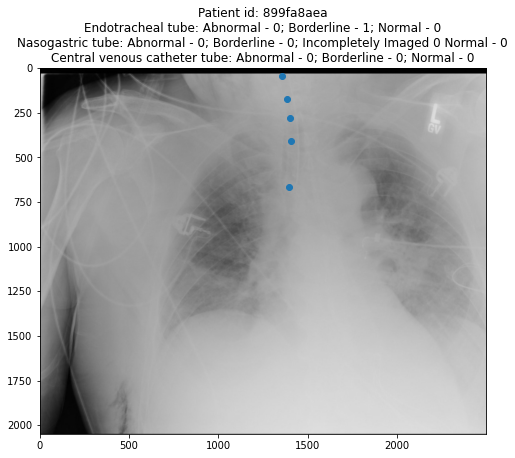

In [15]:
img_ids = df[(df.iloc[:,1:12].sum(axis=1) == 1) & df['ETT - Borderline'] == 1]['StudyInstanceUID']
img_id = path_df[path_df['StudyInstanceUID'].apply(lambda id: id in img_ids.to_list())]['StudyInstanceUID'].iloc[0]
plot_img(img_id)
plt.show()

ETT - Abnormal

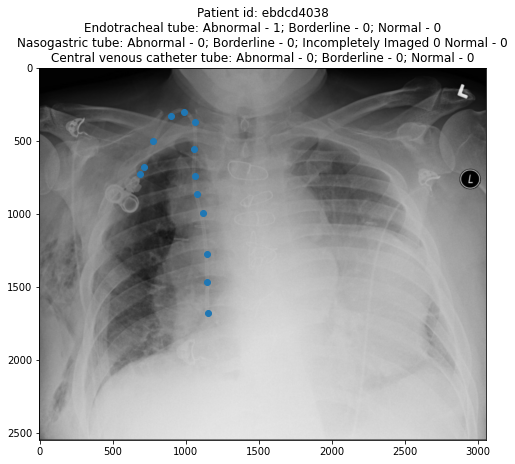

In [16]:
img_ids = df[(df.iloc[:,1:12].sum(axis=1) == 1) & df['ETT - Abnormal'] == 1]['StudyInstanceUID']
img_id = path_df[path_df['StudyInstanceUID'].apply(lambda id: id in img_ids.to_list())]['StudyInstanceUID'].iloc[0]
plot_img(img_id)
plt.show()

NGT - Normal

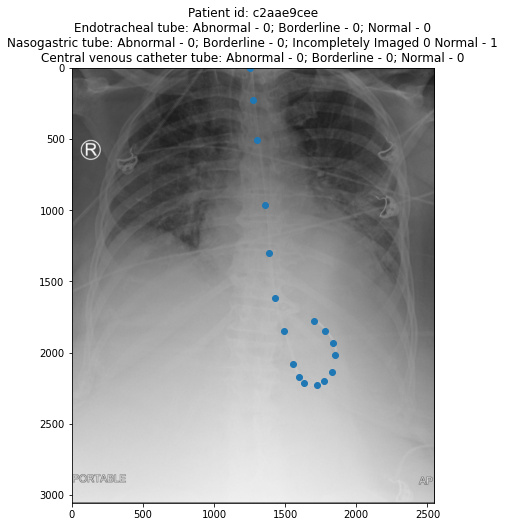

In [17]:
img_ids = df[(df.iloc[:,1:12].sum(axis=1) == 1) & df['NGT - Normal'] == 1]['StudyInstanceUID']
img_id = path_df[path_df['StudyInstanceUID'].apply(lambda id: id in img_ids.to_list())]['StudyInstanceUID'].iloc[0]
plot_img(img_id)
plt.show()

NGT - Borderline

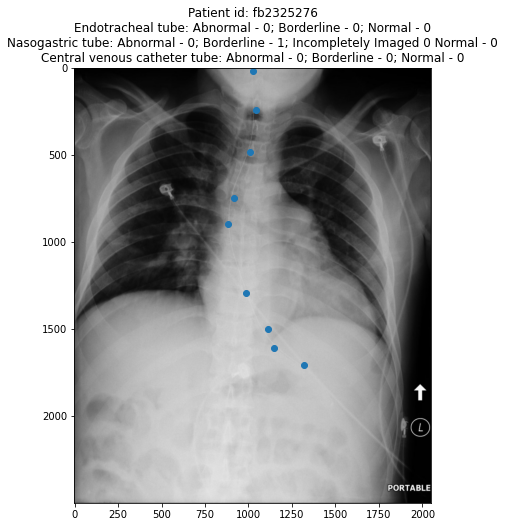

In [18]:
img_ids = df[(df.iloc[:,1:12].sum(axis=1) == 1) & df['NGT - Borderline'] == 1]['StudyInstanceUID']
img_id = path_df[path_df['StudyInstanceUID'].apply(lambda id: id in img_ids.to_list())]['StudyInstanceUID'].iloc[1]
plot_img(img_id)
plt.show()

NGT - Incompletely Imaged

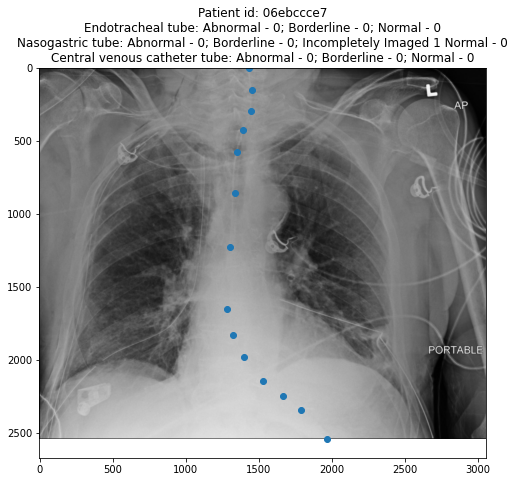

In [19]:
img_ids = df[(df.iloc[:,1:12].sum(axis=1) == 1) & df['NGT - Incompletely Imaged'] == 1]['StudyInstanceUID']
img_id = path_df[path_df['StudyInstanceUID'].apply(lambda id: id in img_ids.to_list())]['StudyInstanceUID'].iloc[0]
plot_img(img_id)
plt.show()

CVC - Normal

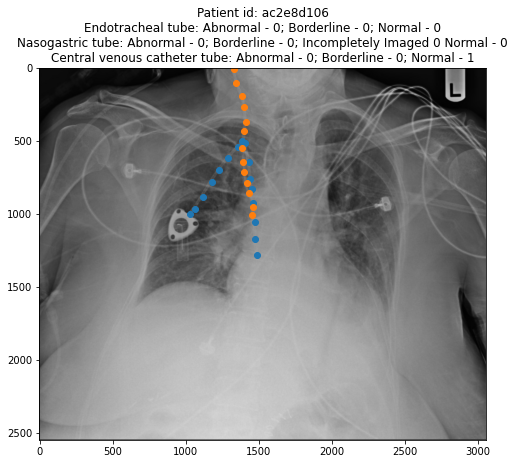

In [20]:
img_ids = df[(df.iloc[:,1:12].sum(axis=1) == 1) & df['CVC - Normal'] == 1]['StudyInstanceUID']
img_id = path_df[path_df['StudyInstanceUID'].apply(lambda id: id in img_ids.to_list())]['StudyInstanceUID'].iloc[0]
plot_img(img_id)
plt.show()

CVC - Borderline

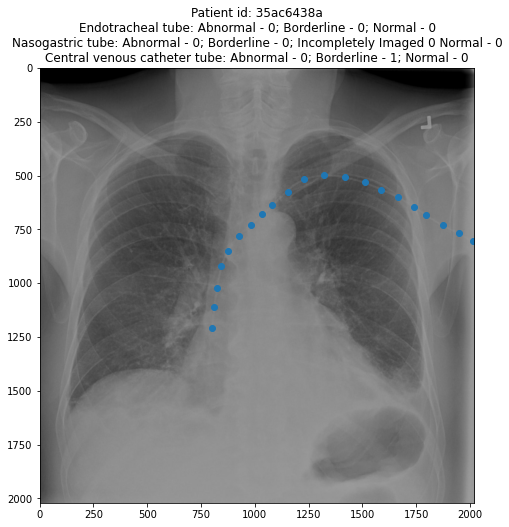

In [21]:
img_ids = df[(df.iloc[:,1:12].sum(axis=1) == 1) & df['CVC - Borderline'] == 1]['StudyInstanceUID']
img_id = path_df[path_df['StudyInstanceUID'].apply(lambda id: id in img_ids.to_list())]['StudyInstanceUID'].iloc[0]
plot_img(img_id)
plt.show()

CVC - Abnormal

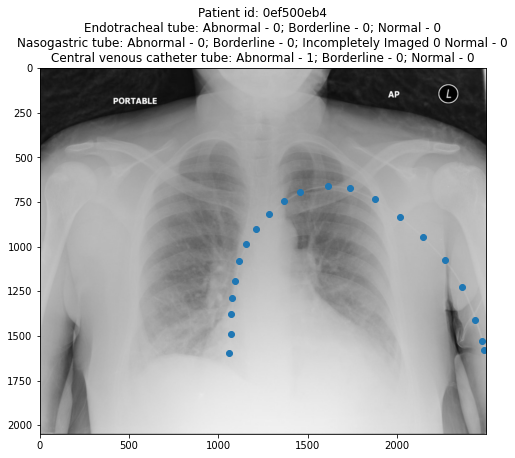

In [22]:
img_ids = df[(df.iloc[:,1:12].sum(axis=1) == 1) & df['CVC - Abnormal'] == 1]['StudyInstanceUID']
img_id = path_df[path_df['StudyInstanceUID'].apply(lambda id: id in img_ids.to_list())]['StudyInstanceUID'].iloc[0]
plot_img(img_id)
plt.show()

Swan Ganz Catheter Present

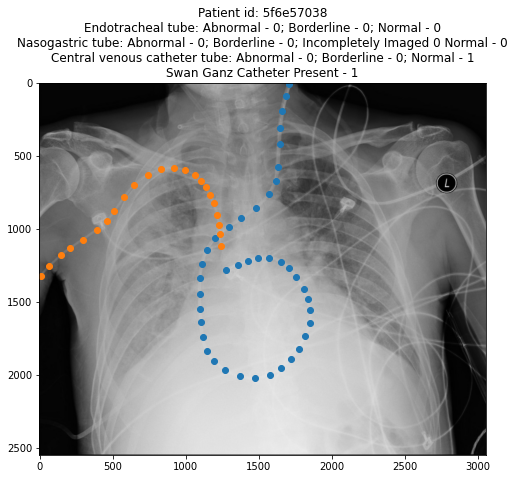

In [23]:
img_ids = df[(df.iloc[:,1:12].sum(axis=1) == 2) & df['Swan Ganz Catheter Present'] == 1]['StudyInstanceUID']
img_id = path_df[path_df['StudyInstanceUID'].apply(lambda id: id in img_ids.to_list())]['StudyInstanceUID'].iloc[2]
plot_img(img_id)
plt.show()

## shared catheter types in the same patient

In [24]:
catheters = ['CVC', 'ETT' , 'NGT', 'Swan Ganz Catheter Present']
catheter_df = pd.DataFrame(index=df.index, columns=catheters)
labels = df.select_dtypes(int).columns
for catheter in catheters:
    group_cols = [label for label in labels if catheter in label]
    catheter_df[catheter] = df[group_cols].sum(axis=1) 

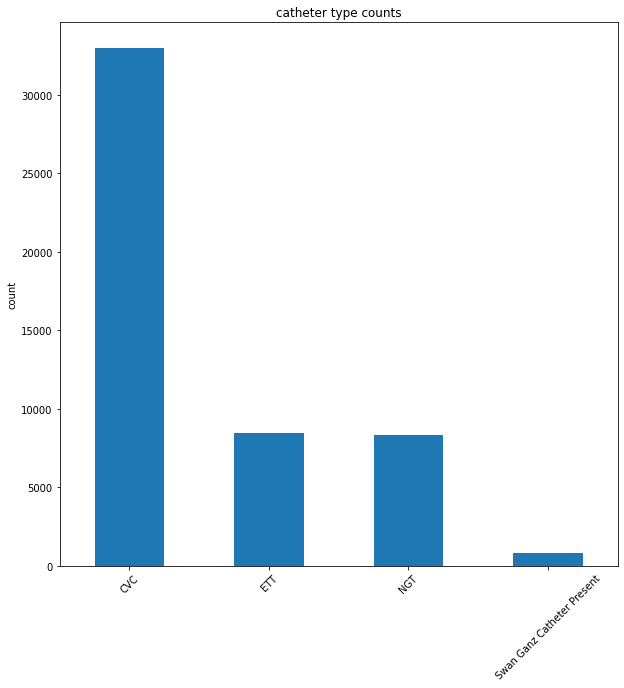

In [25]:
catheter_df.sum().plot(kind='bar', rot=45, figsize=(10,10), fontsize=10,
                       title='catheter type counts')
plt.ylabel('count')
plt.show()

## frequency of multi-label records

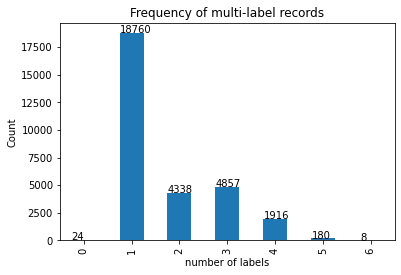

In [26]:
ax = catheter_df.sum(axis=1).value_counts().sort_index().plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.xlabel('number of labels')
plt.ylabel('Count')
plt.title('Frequency of multi-label records')
plt.show()

# EDA over images


## Size distribution

In [ ]:
import pickle
try:
    shape_lst = pickle.load(open("size_df.p", "rb" ) )
except:
    shape_lst = []
    for jpg in Path(train_img_folder).glob('*jpg'):
        img = cv2.imread(str(jpg), cv2.COLOR_BGR2GRAY)
        shape_lst.append(img.shape)
    pickle.dump(size_df, open("size_df.p", "wb" ) )

## general and frequent info

In [28]:
size_df = pd.DataFrame(shape_lst, columns=['height', 'width'])
size_df.describe()

height         width
count  30083.000000  30083.000000
mean    2346.374298   2683.915766
std      349.252643    297.273613
min     1561.000000   1496.000000
25%     2048.000000   2500.000000
50%     2048.000000   2500.000000
75%     2544.000000   3056.000000
max     3567.000000   3827.000000

In [ ]:
shape_lst['tuple'] = shape_lst.apply(lambda row: (f"{row['height']}, {row['width']}"), axis=1)

plt.figure(figsize=(15,5))
X = shape_lst['tuple'].value_counts().head(10).index
height = shape_lst['tuple'].value_counts().head(10).values
plt.bar(X, height)
plt.title('Size destribution of scans')
plt.xlabel('Scan (height, width')
plt.ylabel('Number of scans')
plt.show()

## height and width distribution

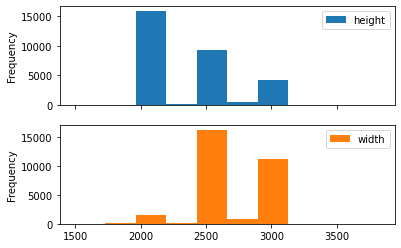

In [29]:
size_df.plot(kind='hist', subplots=True)
plt.show()

In [30]:
print('shortest: {}, longest: {}'.format(sorted(shape_lst)[0], sorted(shape_lst)[-1]))

shortest: (1561, 1702), longest: (3567, 3827)


## preprocessing options

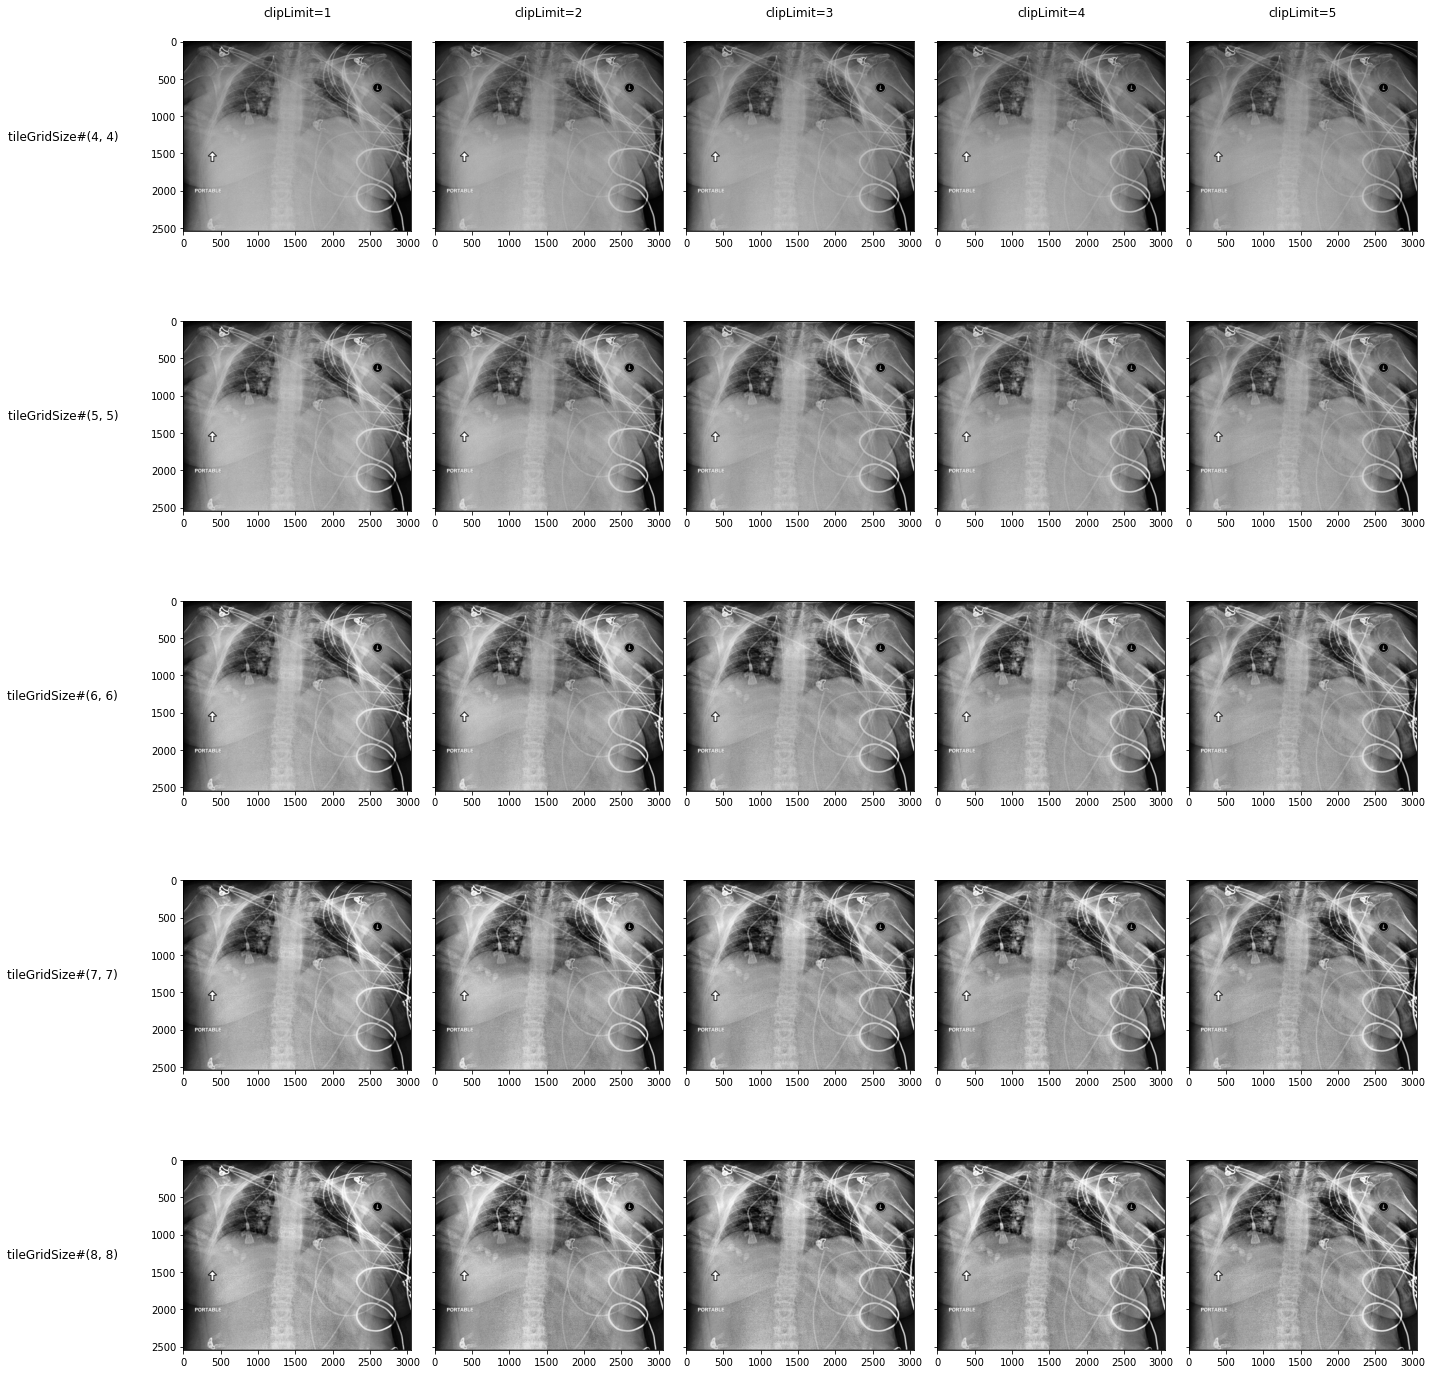

In [31]:
clip_limits = np.arange(1, 6, 1)
tile_grid_sizes = list((size, size) for size in np.arange(4, 9, 1))

_, axes = plt.subplots(nrows=5, ncols=5, figsize=(20,20), sharey=True)

cols = ['clipLimit={}'.format(cl) for cl in clip_limits]
rows = ['tileGridSize#{}'.format(tgs) for tgs in tile_grid_sizes]

for i, clip_limit in enumerate(clip_limits):
    for j, tile_grid_size in enumerate(tile_grid_sizes):
        axes[i,j].imshow(cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size).apply(img), cmap='gray')

pad = len(cols) * len(rows)

for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
plt.tight_layout()
plt.show()

## Intensity plot

In [38]:
counter = Counter()
for jpg in Path(train_img_folder).glob('*jpg'):
    img = cv2.imread(str(jpg), cv2.COLOR_BGR2GRAY)
    counter = counter + Counter(img.ravel().tolist())

In [1]:
pickle.dump(counter, open("intensity_count.p", "wb"))

NameError: ignored

In [ ]:
try:
    intensity_count = pickle.load(open("intensity_count.p", "rb"))
except:
    intensity_count = Counter()
    for jpg in Path(train_img_folder).glob('*jpg'):
        img = cv2.imread(str(jpg), cv2.COLOR_BGR2GRAY)
        intensity_count = intensity_count + Counter(img.ravel().tolist())
    pickle.dump(intensity_count, open("intensity_count.p", "wb"))

In [ ]:
pd.DataFrame(intensity_count.items(), columns=['intensity', 'avg_pixel_count']).sort_values(by='intensity')